# SUPERSMARTHOME


### 0: INSTALLING LIBRARIES

In [6]:
# !pip install llama_index chroma chromadb openai logging llama-index-experimental
# !pip install -r requirements.txt


### 0: IMPORTING LIBRARIES
Using pre-built class for directory reading.

In [7]:
import os
import sys
import logging
import chromadb
import pandas as pd
from IPython.display import Markdown, display
import re

from llama_index.core import StorageContext
from llama_index.core import Settings
from llama_index.core import SimpleDirectoryReader
from llama_index.experimental.query_engine import PandasQueryEngine
from llama_index.embeddings.openai import OpenAIEmbedding


In [8]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

### 1: IMPORTING OPENAPI KEY

In [9]:
# first, load and set openaikey from a txt file I stored it in
with open('oaikey.txt') as keyfile:
    oaikey = keyfile.read().strip()
    
os.environ["OPENAI_API_KEY"] = oaikey

#### 2: IMPORTING DATASET 

In [10]:
# File paths for each room
room_files = {
    'QDORO': './MQTT Client/Room MQTT Client/data/airQDORO.csv',
    'QFOYER': './MQTT Client/Room MQTT Client/data/airQFOYER.csv',
    'QHANS': './MQTT Client/Room MQTT Client/data/airQHANS.csv',
    'QMOMO': './MQTT Client/Room MQTT Client/data/airQMOMO.csv',
    'QRITA': './MQTT Client/Room MQTT Client/data/airQRITA.csv',
    'QROB': './MQTT Client/Room MQTT Client/data/airQROB.csv'
}

# Load each room's data into separate DataFrames
df_QDORO = pd.read_csv(room_files['QDORO'])
df_QFOYER = pd.read_csv(room_files['QFOYER'])
df_QHANS = pd.read_csv(room_files['QHANS'])
df_QMOMO = pd.read_csv(room_files['QMOMO'])
df_QRITA = pd.read_csv(room_files['QRITA'])
df_QROB = pd.read_csv(room_files['QROB'])

df_rooftop = pd.read_csv('./MQTT Client/Roof MQTT Client/data/pivoted_data.csv')


In [11]:
# Optionally, convert timestamp to datetime if needed
df_QDORO['timestamp'] = pd.to_datetime(df_QDORO['timestamp'])
df_QFOYER['timestamp'] = pd.to_datetime(df_QFOYER['timestamp'])
df_QHANS['timestamp'] = pd.to_datetime(df_QHANS['timestamp'])
df_QMOMO['timestamp'] = pd.to_datetime(df_QMOMO['timestamp'])
df_QRITA['timestamp'] = pd.to_datetime(df_QRITA['timestamp'])
df_QROB['timestamp'] = pd.to_datetime(df_QROB['timestamp'])

df_rooftop['timestamp'] = pd.to_datetime(df_rooftop['timestamp_utc'])

### 3: BUILDING PANDAS QUERY ENGINE

In [12]:
# Internal Rooms
query_engine_DORO = PandasQueryEngine(df=df_QDORO, verbose=True)
query_engine_FOYER = PandasQueryEngine(df=df_QFOYER, verbose=True)
query_engine_HANS = PandasQueryEngine(df=df_QHANS, verbose=True)
query_engine_MOMO = PandasQueryEngine(df=df_QMOMO, verbose=True)
query_engine_RITA = PandasQueryEngine(df=df_QRITA, verbose=True)
query_engine_ROB = PandasQueryEngine(df=df_QROB, verbose=True)

# External Rooms
query_engine_rooftop = PandasQueryEngine(df=df_rooftop, verbose=True)

### 4: QUERYING THE DATA

##### 4.1: ROOFTOP QUERYING

In [13]:
room_choice = "ROOFTOP"   # "DORO", "FOYER", "HANS", "MOMO", "RITA", "ROB"

In [14]:
# Set query_engine_choice based on the internal/external choice and the room choice
if room_choice == "QDORO":
    query_engine_choice = query_engine_DORO
elif room_choice == "QFOYER":
    query_engine_choice = query_engine_FOYER
elif room_choice == "QHANS":
    query_engine_choice = query_engine_HANS
elif room_choice == "QMOMO":
    query_engine_choice = query_engine_MOMO
elif room_choice == "QRITA":
    query_engine_choice = query_engine_RITA
elif room_choice == "QROB":
    query_engine_choice = query_engine_ROB
elif room_choice == "ROOFTOP":
    query_engine_choice = query_engine_rooftop
else:
    raise ValueError(f"Unknown Room choice: {room_choice}")


In [15]:
df_rooftop

,timestamp_utc,sensor_sn,Air Temperature,Atmospheric Pressure,EC,Gust Speed,Max Air Temperature,Max Precip Rate,Min Air Temperature,Precipitation,RH Sensor Temp,Solar Radiation,Tilt Angle,VPD,Vapor Pressure,Wind Direction,Wind Speed,timestamp
0,1719784800,A4100209,20.0,98.00,0.0,2.11,20.1,0.0,20.0,0.0,19.7,0.0,1.4,0.28,2.067,289.7,0.68,1970-01-01 00:00:01.719784800
1,1719785100,A4100209,20.1,98.00,0.0,2.48,20.1,0.0,20.0,0.0,19.8,0.0,1.4,0.29,2.060,302.9,0.75,1970-01-01 00:00:01.719785100
2,1719785400,A4100209,20.1,98.01,0.0,2.38,20.2,0.0,20.0,0.0,19.8,0.0,1.4,0.30,2.054,298.2,0.72,1970-01-01 00:00:01.719785400
3,1719785700,A4100209,20.1,98.01,0.0,1.80,20.2,0.0,20.0,0.0,19.9,0.0,1.3,0.30,2.047,292.3,0.85,1970-01-01 00:00:01.719785700
4,1719786000,A4100209,20.1,98.02,0.0,3.53,20.2,0.0,20.0,0.0,19.9,0.0,1.3,0.32,2.036,286.0,0.99,1970-01-01 00:00:01.719786000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,1719956400,A4100209,15.8,98.04,0.0,0.64,15.9,0.0,15.7,0.0,15.9,0.0,1.3,0.41,1.380,197.7,0.34,1970-01-01 00:00:01.719956400
573,1719956700,A4100209,15.7,98.04,0.0,0.54,15.8,0.0,15.6,0.0,15.8,0.0,1.4,0.40,1.378,194.1,0.24,1970-01-01 00:00:01.719956700
574,1719957000,A4100209,15.7,98.03,0.0,0.74,15.8,0.0,15.5,0.0,15.7,0.0,1.4,0.41,1.370,148.3,0.25,1970-01-01 00:00:01.719957000
575,1719957300,A4100209,15.6,98.03,0.0,1.05,15.7,NaN,15.5,0.0,15.7,0.0,1.3,0.41,1.362,172.4,0.49,1970-01-01 00:00:01.719957300


In [16]:
query = f"Please provide me the set of air temperature values during last day in {room_choice}"

response = query_engine_choice.query(
    query
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
> Pandas Instructions:
```
df[df['timestamp_utc'] >= df['timestamp_utc'].max() - 86400]['Air Temperature']
```
> Pandas Output: 288    16.3
289    16.3
290    16.3
291    16.2
292    16.3
       ... 
572    15.8
573    15.7
574    15.7
575    15.6
576    15.6
Name: Air Temperature, Length: 289, dtype: float64


In [17]:
# Assuming you have a Response object named 'response'
actual_response = response.response

# Now you can print or further process the actual response string
print(actual_response)

288    16.3
289    16.3
290    16.3
291    16.2
292    16.3
       ... 
572    15.8
573    15.7
574    15.7
575    15.6
576    15.6
Name: Air Temperature, Length: 289, dtype: float64


##### 4.2: DORO QUERYING

In [18]:
# Internal Rooms
query_engine_DORO = PandasQueryEngine(df=df_QDORO, verbose=True)
query_engine_FOYER = PandasQueryEngine(df=df_QFOYER, verbose=True)
query_engine_HANS = PandasQueryEngine(df=df_QHANS, verbose=True)
query_engine_MOMO = PandasQueryEngine(df=df_QMOMO, verbose=True)
query_engine_RITA = PandasQueryEngine(df=df_QRITA, verbose=True)
query_engine_ROB = PandasQueryEngine(df=df_QROB, verbose=True)

# External Rooms
query_engine_rooftop = PandasQueryEngine(df=df_rooftop, verbose=True)

In [19]:
room_choice = "QRITA"   # "QDORO", "QFOYER", "QHANS", "QMOMO", "QRITA", "QROB"


In [20]:
# Set query_engine_choice based on the internal/external choice and the room choice
if room_choice == "QDORO":
    query_engine_choice = query_engine_DORO
elif room_choice == "QFOYER":
    query_engine_choice = query_engine_FOYER
elif room_choice == "QHANS":
    query_engine_choice = query_engine_HANS
elif room_choice == "QMOMO":
    query_engine_choice = query_engine_MOMO
elif room_choice == "QRITA":
    query_engine_choice = query_engine_RITA
elif room_choice == "QROB":
    query_engine_choice = query_engine_ROB
elif room_choice == "ROOFTOP":
    query_engine_choice = query_engine_rooftop
else:
    raise ValueError(f"Unknown Room choice: {room_choice}")


In [21]:
timestep_request = 'and the timestamp'
query = f"Please provide me all the health {timestep_request} values during first day in the room {room_choice}."
# query = query + ' Provide also the timestamp column associated to the result.'
print(query)
response = query_engine_choice.query(
    query,
)

Please provide me all the health and the timestamp values during first day in the room QRITA.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
> Pandas Instructions:
```
df.loc[df['timestamp'].dt.date == pd.to_datetime('1970-01-01').date(), ['health', 'timestamp']]
```
> Pandas Output:     health                  timestamp
0      333 1970-01-01 00:28:45.009675
1      337 1970-01-01 00:28:45.009707
2      338 1970-01-01 00:28:45.009715
3      338 1970-01-01 00:28:45.009723
4      338 1970-01-01 00:28:45.009731
..     ...                        ...
87     341 1970-01-01 00:28:45.010416
88     343 1970-01-01 00:28:45.010452
89     343 1970-01-01 00:28:45.010460
90     343 1970-01-01 00:28:45.010460
91     342 1970-01-01 00:28:45.010468

[92 rows x 2 columns]


In [22]:
# Assuming you have a Response object named 'response'
actual_response = response.response

# Now you can print or further process the actual response string
print(actual_response)


    health                  timestamp
0      333 1970-01-01 00:28:45.009675
1      337 1970-01-01 00:28:45.009707
2      338 1970-01-01 00:28:45.009715
3      338 1970-01-01 00:28:45.009723
4      338 1970-01-01 00:28:45.009731
..     ...                        ...
87     341 1970-01-01 00:28:45.010416
88     343 1970-01-01 00:28:45.010452
89     343 1970-01-01 00:28:45.010460
90     343 1970-01-01 00:28:45.010460
91     342 1970-01-01 00:28:45.010468

[92 rows x 2 columns]


In [23]:
import pandas as pd
import re

# Split the string into lines
lines = actual_response.split('\n')

# Extract the column names from the first line
column_names = lines[0].strip().split()

# Filter out lines that contain '..' or are empty
filtered_lines = [line for line in lines[1:] if line.strip() and '..' not in line]

# Use regex to extract health and timestamp values
parsed_data = []
for line in filtered_lines:
    match = re.match(r'\s*(\d+)\s+(\d+)\s+([\d-]+ [\d:.]+)', line)
    if match:
        health = int(match.group(2))  # The first column (health)
        timestamp = match.group(3)  # The second column (timestamp)
        parsed_data.append((health, timestamp))

# Convert to DataFrame using the column names from the first line
df_response = pd.DataFrame(parsed_data, columns=column_names)

# Remove the last row
df_response = df_response.iloc[:-1]

df_response['timestamp'] = pd.to_datetime(df_response['timestamp'], errors='coerce')

# # Display the resulting DataFrame
print(df_response)

   health                  timestamp
0     333 1970-01-01 00:28:45.009675
1     337 1970-01-01 00:28:45.009707
2     338 1970-01-01 00:28:45.009715
3     338 1970-01-01 00:28:45.009723
4     338 1970-01-01 00:28:45.009731
5     341 1970-01-01 00:28:45.010416
6     343 1970-01-01 00:28:45.010452
7     343 1970-01-01 00:28:45.010460
8     343 1970-01-01 00:28:45.010460


In [24]:
df_response

,health,timestamp
0,333,1970-01-01 00:28:45.009675
1,337,1970-01-01 00:28:45.009707
2,338,1970-01-01 00:28:45.009715
3,338,1970-01-01 00:28:45.009723
4,338,1970-01-01 00:28:45.009731
5,341,1970-01-01 00:28:45.010416
6,343,1970-01-01 00:28:45.010452
7,343,1970-01-01 00:28:45.010460
8,343,1970-01-01 00:28:45.010460


In [25]:
from openai import OpenAI
client = OpenAI(api_key=oaikey)
chat_completion = client.chat.completions.create(
    model='gpt-4o-mini',
    messages=[{'role': 'user', 
               'content': f'Here it is the user query: {query}.'
               'Generate python code that prints a line chart of the full data. The chart should include timestamp on the x axis and the other value on the y-axis'
               #'For the plotting, about the timestamp, take into consideration for the labels only the day, hours, minutes and seconds information.'
               f'For the data use the following dataframe: {df_response}.'
               'The dataframe df_response only contains results about the room the user is interested in.'
               'Only print the python code. Do not include comments.'
               'Do not output any other text before or after the code.'}])

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [26]:
code = chat_completion.choices[0].message.content[9:-3]

In [27]:
print(code)


import pandas as pd
import matplotlib.pyplot as plt

data = {
    'health': [333, 337, 338, 338, 338, 341, 343, 343, 343],
    'timestamp': [
        '1970-01-01 00:28:45.009675',
        '1970-01-01 00:28:45.009707',
        '1970-01-01 00:28:45.009715',
        '1970-01-01 00:28:45.009723',
        '1970-01-01 00:28:45.009731',
        '1970-01-01 00:28:45.010416',
        '1970-01-01 00:28:45.010452',
        '1970-01-01 00:28:45.010460',
        '1970-01-01 00:28:45.010460'
    ]
}

df_response = pd.DataFrame(data)
df_response['timestamp'] = pd.to_datetime(df_response['timestamp'])

plt.figure(figsize=(10, 5))
plt.plot(df_response['timestamp'], df_response['health'], marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Health')
plt.title('Health vs Timestamp in room QRITA')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



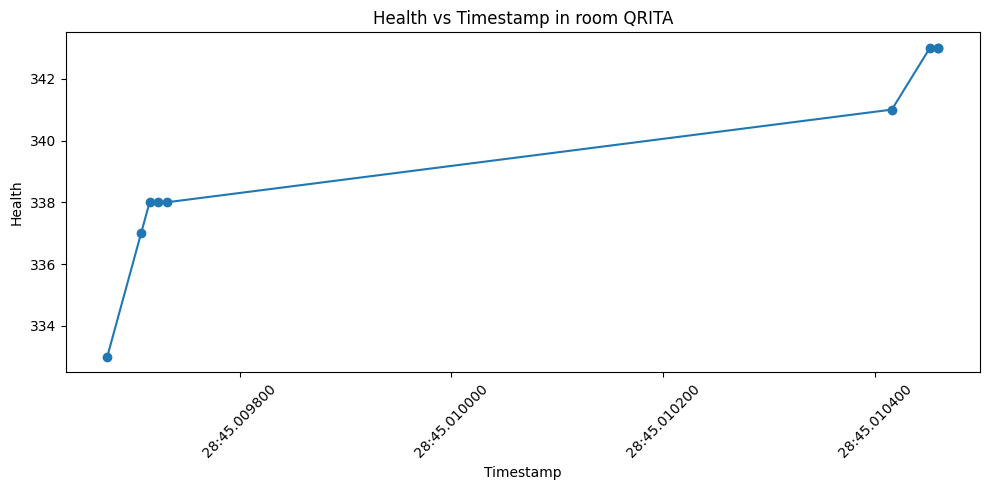

In [28]:
exec(code)